In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dectección de anomalias (Local Outlier Factor)

### LIBRERIAS

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;
from sklearn.neighbors import LocalOutlierFactor
import numpy as np


### CARGA DE DATOS

In [3]:
dfext = pd.read_csv('/content/drive/MyDrive/MAESTRIA-CIENCIA-DATOS/MATERIAS/INGENIERIA-DE-CARACTERISTICAS/OUTLIERDETECTION/deteccionAnomalias/data/remaining_behavior_ext.csv') 
dfsup = pd.read_csv('/content/drive/MyDrive/MAESTRIA-CIENCIA-DATOS/MATERIAS/INGENIERIA-DE-CARACTERISTICAS/OUTLIERDETECTION/deteccionAnomalias/data/supervised_dataset.csv')

Imprimiendo los datos

In [5]:
dfsup.head(10)

,Unnamed: 0,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_users,num_unique_apis,source,classification
0,0,0.000812,0.004066,85.643243,5405,default,1460.0,1295.0,451.0,E,normal
1,1,0.000063,0.002211,16.166805,519,default,9299.0,8447.0,302.0,E,normal
2,2,0.004481,0.015324,99.573276,6211,default,255.0,232.0,354.0,E,normal
3,3,0.017837,0.014974,69.792793,8292,default,195.0,111.0,116.0,E,normal
4,4,0.000797,0.006056,14.952756,182,default,272.0,254.0,23.0,E,normal
5,5,0.001660,0.005821,92.222222,7359,default,897.0,801.0,430.0,E,normal
6,6,0.004798,0.012119,100.098361,8790,default,342.0,305.0,370.0,E,normal
7,7,0.007570,0.008834,65.746725,6839,default,240.0,229.0,133.0,E,normal
8,8,0.000708,0.014712,7.526846,96,default,326.0,298.0,33.0,E,normal
9,9,0.000799,0.004379,79.392024,5056,default,1471.0,1329.0,462.0,E,normal


## ANALISIS EXPLORATORIO

### ESTRUCTURA DE DATOS

Figura de los datos

In [6]:
dfsup.shape

(1560, 11)

Estructura

In [7]:
#Estructura de datos
dfsup.dtypes

Unnamed: 0                          int64
inter_api_access_duration(sec)    float64
api_access_uniqueness             float64
sequence_length(count)            float64
vsession_duration(min)              int64
ip_type                            object
num_sessions                      float64
num_users                         float64
num_unique_apis                   float64
source                             object
classification                     object
dtype: object

Descripción

In [8]:
dfsup.describe()

,Unnamed: 0,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),num_sessions,num_users,num_unique_apis
count,1560.000000,1560.000000,1560.000000,1560.000000,1.560000e+03,1560.000000,1560.000000,1560.000000
mean,779.500000,0.858996,0.153479,58.215141,6.297617e+03,614.283333,442.373718,72.175000
std,450.477524,4.875142,0.275511,185.849968,4.847140e+04,1219.123408,994.647978,83.891631
min,0.000000,0.000003,0.001200,2.000000,1.000000e+00,2.000000,1.000000,1.000000
25%,389.750000,0.000638,0.008701,10.183704,7.075000e+01,13.000000,1.000000,16.000000
50%,779.500000,0.001831,0.016063,17.000000,1.935000e+02,187.000000,155.000000,42.000000
75%,1169.250000,0.015128,0.137941,38.331612,4.010750e+03,531.000000,356.250000,97.000000
max,1559.000000,84.045074,1.000000,3303.000000,1.352948e+06,9299.000000,8447.000000,524.000000


### Diccionario de los datos
- inter_api_access_duration(sec): Intervalo de tiempo entre dos accesos consecutivos a la API en una sesión de usuario.
- api_access_uniqueness: La proporción del número de APIs distintas vistas en una sesión de un usuario con respecto al total de llamadas hechas a la API en esa sesión.
- sequence_length(count): El número total de llamadas a API hechas en una sesión por una usuario en promedio.
- vsession_duration(min): La duración de una sesión de usuario dentro de una ventana de observación en minutos.
- ip_type: El tipo de IP de donde proviene el usuario.
- num_sessions: Número de sesiones de usuario cada una con diferente session_id.
- num_users: Número de usuarios generando el mismo tipo de secuencias de llamadas de API.
- num_unique_apis: Número de APIs distintas en ese grupo de comportamiento (behavior group).
- source: Origen de los datos. F = Financial services, E = Ecommerce.
- classification: Clasificación, outlier o normal.

### Limpieza de datos

Normalizar

In [12]:
dfsup["vsession_duration(min)"] = 60 * dfsup["vsession_duration(min)"]

In [13]:
dfsup.isna().sum()

Unnamed: 0                        0
inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [ ]:
Elimnar columnas 

In [40]:
#Drop Nans
dftidy = dfsup.dropna()
#Drop Unnamed classification columns
#dftidy =dftidy.drop(['classification'], axis=1)
dftidy =dftidy.drop(dftidy.columns[[0]], axis=1)
dftidy =dftidy.drop(['num_users'], axis=1)
#Make Columns type Factor
dftidy['source'] = dftidy['source'].astype('category')
dftidy['ip_type'] = dftidy['ip_type'].astype('category')

dftidy.dtypes

inter_api_access_duration(sec)     float64
api_access_uniqueness              float64
sequence_length(count)             float64
vsession_duration(min)               int64
ip_type                           category
num_sessions                       float64
num_unique_apis                    float64
source                            category
classification                      object
dtype: object

In [41]:
dftidy.shape

(1560, 9)

Remover Duplicados

In [42]:
dftidy.duplicated().sum()

26

In [43]:
dftidy = dftidy.drop_duplicates()
dftidy

,inter_api_access_duration(sec),api_access_uniqueness,sequence_length(count),vsession_duration(min),ip_type,num_sessions,num_unique_apis,source,classification
0,0.000812,0.004066,85.643243,324300,default,1460.0,451.0,E,normal
1,0.000063,0.002211,16.166805,31140,default,9299.0,302.0,E,normal
2,0.004481,0.015324,99.573276,372660,default,255.0,354.0,E,normal
3,0.017837,0.014974,69.792793,497520,default,195.0,116.0,E,normal
4,0.000797,0.006056,14.952756,10920,default,272.0,23.0,E,normal
...,...,...,...,...,...,...,...,...,...
1555,9.324284,0.405405,37.000000,1242000,default,2.0,15.0,F,outlier
1556,9.141667,1.000000,6.000000,197460,default,2.0,6.0,F,outlier
1557,4.177931,0.170213,94.000000,1413840,default,2.0,16.0,F,outlier
1558,9.253941,0.764706,17.000000,566400,default,2.0,13.0,F,outlier


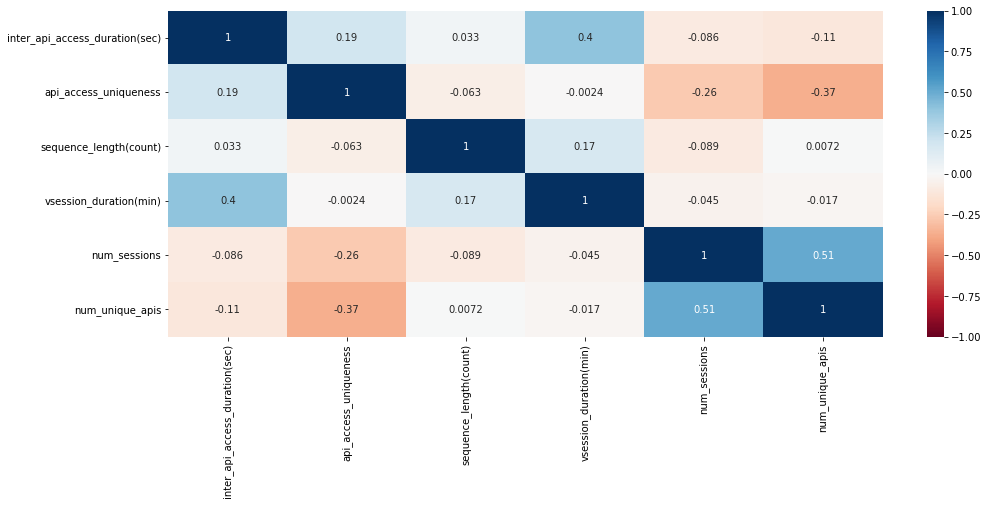

In [26]:
plt.figure(figsize=(16,6))
sns.heatmap(dftidy.corr(),vmin=-1, vmax=1, annot=True,cmap='RdBu')
#heatmap.set_title('Correlacion Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

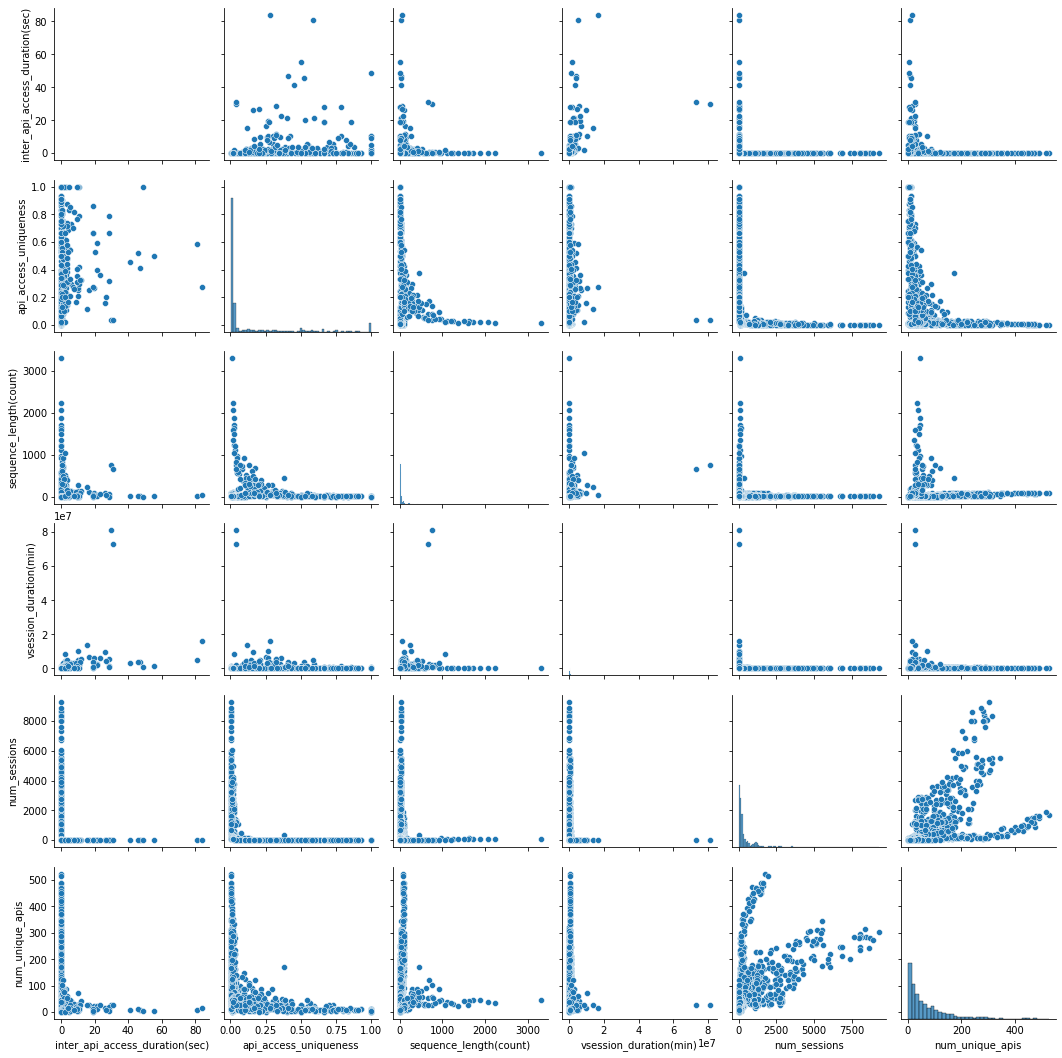

In [44]:
sns.pairplot(dftidy) 
plt.show()

## LOCAL OUTLIER FACTOR

In [45]:
X = dftidy[["num_sessions", "inter_api_access_duration(sec)"]].to_numpy()
X.shape

(1534, 2)

Numero de sesiones / intervalo de accesos a la api

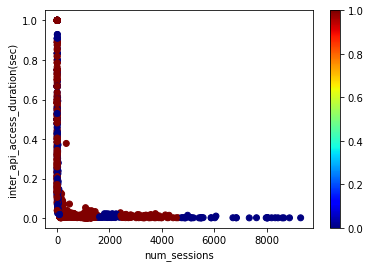

In [57]:
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(X)

plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_sessions")
plt.ylabel("inter_api_access_duration(sec)")
plt.colorbar()
plt.show()

Proporcion

In [55]:
np.where(estimado_LOF > 0.0,1,0).mean() 

0.8513689700130378

Numero de sesiones / duración en llamadas por api

---



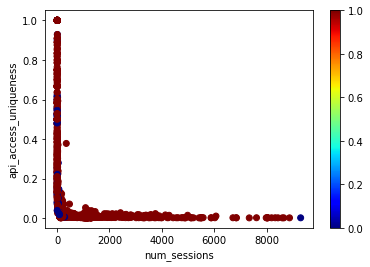

In [51]:
X = dftidy[["num_sessions", "api_access_uniqueness"]].to_numpy()
X.shape
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(X)

plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_sessions")
plt.ylabel("api_access_uniqueness")
plt.colorbar()
plt.show()

Numero de sesiones / Número de APIs distintas 

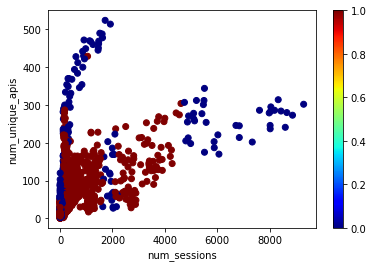

In [50]:
X = dftidy[["num_sessions", "num_unique_apis"]].to_numpy()
X.shape
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(X)

plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_sessions")
plt.ylabel("num_unique_apis")
plt.colorbar()
plt.show()